In [1]:
# !pip install pandas


In [2]:
# dqn_hyperparam_tuning.ipynb

import os
import sys
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import traci
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd


In [3]:
# --- SUMO Configuration ---
def sumo_config(traffic_pattern="P1"):
    sumo_config = [
        "sumo",
        "-c", f"SUMO_networks/{traffic_pattern}/junction.sumocfg",
        "--step-length", "0.05",
        "--delay", "0",
        "--lateral-resolution", "0.1",
        "--start",
        "--no-warnings",
        "--no-step-log",
    ]
    return sumo_config

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

if not traci.isLoaded():
    traci.start(sumo_config())


In [4]:
# --- Global Variables ---
action_space_size = 8
TRAFFIC_LIGHT_ID = "traffic_light"
DELTA_PHASE_DURATION = 6
YELLOW_PHASE_DURATION = 4
lane_detectors = [f'q{i+1}' for i in range(8)]
current_phase = 2
frame_buffer = deque(maxlen=4)

def get_queue_length():
    return torch.tensor([
        traci.lanearea.getLastStepHaltingNumber(d) for d in lane_detectors
    ], dtype=torch.float)

def generate_occupancy_grid(grid_size=(84, 84),
                             bounds=(-91.5, 76.5, -66.5, 101.5)):
    x_min, x_max, y_min, y_max = bounds
    x_scale = grid_size[1] / (x_max - x_min)
    y_scale = grid_size[0] / (y_max - y_min)

    grid = torch.zeros(grid_size, dtype=torch.float32)

    for v_id in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(v_id)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = int((x - x_min) * x_scale)
            row = int((y - y_min) * y_scale)

            if 0 <= row < grid_size[0] and 0 <= col < grid_size[1]:
                grid[row, col] = 1.0  

    return grid

def get_current_state():
    frame_buffer.clear()  # clear previous frames to maintain consistency

    for _ in range(4):
        simulate_time(1)  # simulate 1 second
        grid = generate_occupancy_grid()
        frame_buffer.append(grid.unsqueeze(0))

    # if len(frame_buffer) >= 2:
    #     second_recent = frame_buffer[-2].squeeze(0)  # shape: [84, 84]
    #     plt.figure(figsize=(6, 6))
    #     plt.imshow(second_recent.numpy(), cmap='gray', origin='lower')
    #     plt.title("Previous Occupancy Grid")
    #     plt.xlabel("X-axis (cols)")
    #     plt.ylabel("Y-axis (rows)")
    #     plt.colorbar(label='Occupancy')
    #     plt.grid(False)
    #     plt.tight_layout()
    #     plt.show()

    # # Plot latest grid
    # plt.figure(figsize=(6, 6))
    # plt.imshow(grid.numpy(), cmap='gray', origin='lower')
    # plt.title("Latest Occupancy Grid")
    # plt.xlabel("X-axis (cols)")
    # plt.ylabel("Y-axis (rows)")
    # plt.colorbar(label='Occupancy')
    # plt.grid(False)
    # plt.tight_layout()
    # plt.show()
    
    state = torch.cat(list(frame_buffer), dim=0)
    return state
    

def simulate_time(seconds=1):
    for _ in range(20 * seconds):
        traci.simulationStep()

def step(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    next_state = get_current_state()
    queue_length = get_queue_length()
    reward = -torch.sum(queue_length)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv3(x))   
        
        x = x.view(x.size(0), -1)   
        x = F.relu(self.fc1(x))
        return self.output(x)      


In [6]:
# --- Environment Switching ---
import itertools
traffic_patterns = itertools.cycle(["P1", "P2", "P3", "P4"])

def change_env():
    pattern = next(traffic_patterns)
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern))


In [7]:
# --- Choose Action ---
def choose_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_space_size - 1)
    else:
        return torch.argmax(policy_net(state.unsqueeze(0))).item()


In [8]:
# --- Optimizer Step ---
def optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states = torch.stack([x[0] for x in batch])
    actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
    rewards = torch.tensor([x[2] for x in batch], dtype=torch.float)
    next_states = torch.stack([x[3] for x in batch])
    dones = torch.tensor([x[4] for x in batch], dtype=torch.float)

    q_vals = policy_net(states).gather(1, actions).squeeze()
    with torch.no_grad():
        max_next_q_vals = target_net(next_states).max(1)[0]
        target_vals = rewards + gamma * max_next_q_vals * (1 - dones)
    loss = nn.MSELoss()(q_vals, target_vals)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [9]:
# --- Training Loop ---
def train_algorithm(params, episodes=1):
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    policy_net = DQN(action_space_size)
    target_net = DQN(action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    rewards_per_episode = []
    steps_done = 0

    for episode in range(episodes):
        print(f"Episode: {episode}")
        change_env()
        state = get_current_state()
        episode_reward = 0
        done = False

        while not done:
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done = step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward
            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(episode_reward.item())
        print(episode_reward)

    recent_rewards = rewards_per_episode[-40:] if len(rewards_per_episode) >= 40 else rewards_per_episode
    return sum(recent_rewards) / len(recent_rewards), rewards_per_episode


In [10]:
# --- Grid Search ---
param_grid = {
    "gamma": [0.999],
    "epsilon": [0.9],
    "epsilon_decay": [0.95, 0.97],
    "min_epsilon": [0.05],
    "learning_rate": [0.001],
    "batch_size": [128],
    "target_update_freq": [1800],
    "memory_size": [10000, 20000],
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

Running combo: {'gamma': 0.999, 'epsilon': 0.9, 'epsilon_decay': 0.95, 'min_epsilon': 0.05, 'learning_rate': 0.001, 'batch_size': 128, 'target_update_freq': 1800, 'memory_size': 10000}
Episode: 0
tensor(-5248.)
Episode: 1
tensor(-9865.)
Episode: 2
tensor(-7727.)
Episode: 3
tensor(-333.)
Episode: 4
tensor(-3433.)
Episode: 5
tensor(-4617.)
Episode: 6
tensor(-3560.)
Episode: 7
tensor(-92.)
Episode: 8
tensor(-2172.)
Episode: 9
tensor(-3383.)
Episode: 10
tensor(-2581.)
Episode: 11
tensor(-84.)
Episode: 12
tensor(-2065.)
Episode: 13
tensor(-2682.)
Episode: 14
tensor(-3201.)
Episode: 15
tensor(-98.)
Episode: 16
tensor(-1869.)
Episode: 17
tensor(-1949.)
Episode: 18
tensor(-2441.)
Episode: 19
tensor(-53.)
Episode: 20
tensor(-1701.)
Episode: 21
tensor(-1738.)
Episode: 22
tensor(-2603.)
Episode: 23
tensor(-49.)
Episode: 24
tensor(-1412.)
Episode: 25
tensor(-1793.)
Episode: 26
tensor(-2039.)
Episode: 27
tensor(-46.)
Episode: 28
tensor(-1492.)
Episode: 29
tensor(-1750.)
Episode: 30
tensor(-1921.)
E

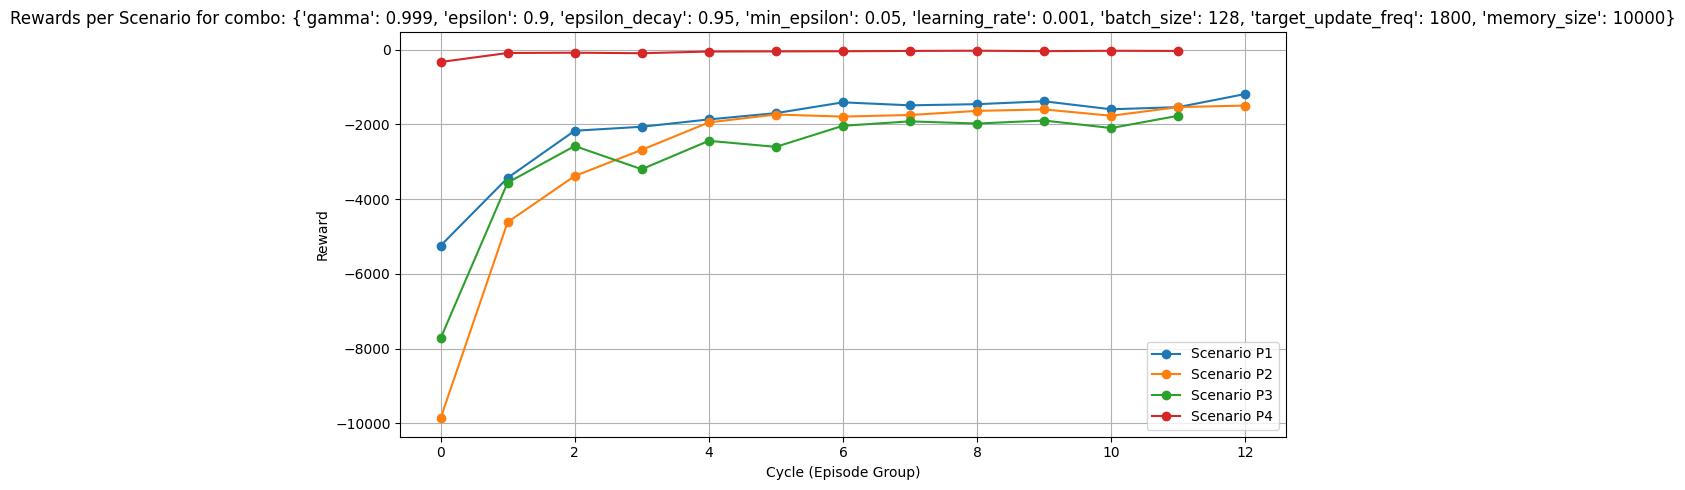

Running combo: {'gamma': 0.999, 'epsilon': 0.9, 'epsilon_decay': 0.95, 'min_epsilon': 0.05, 'learning_rate': 0.001, 'batch_size': 128, 'target_update_freq': 1800, 'memory_size': 20000}
Episode: 0
tensor(-6016.)
Episode: 1
tensor(-433.)
Episode: 2
tensor(-4928.)
Episode: 3
tensor(-7001.)
Episode: 4
tensor(-4870.)
Episode: 5
tensor(-187.)
Episode: 6
tensor(-3078.)
Episode: 7
tensor(-3672.)
Episode: 8
tensor(-3308.)
Episode: 9
tensor(-97.)
Episode: 10
tensor(-2157.)
Episode: 11
tensor(-3071.)
Episode: 12
tensor(-3431.)
Episode: 13
tensor(-237.)
Episode: 14
tensor(-1930.)
Episode: 15
tensor(-1963.)
Episode: 16
tensor(-2374.)
Episode: 17
tensor(-67.)
Episode: 18
tensor(-1541.)
Episode: 19
tensor(-2225.)
Episode: 20
tensor(-2758.)
Episode: 21
tensor(-49.)
Episode: 22
tensor(-2175.)
Episode: 23
tensor(-2033.)
Episode: 24
tensor(-2234.)
Episode: 25
tensor(-38.)
Episode: 26
tensor(-1649.)
Episode: 27
tensor(-2174.)
Episode: 28
tensor(-1933.)
Episode: 29
tensor(-54.)
Episode: 30
tensor(-1673.)
E

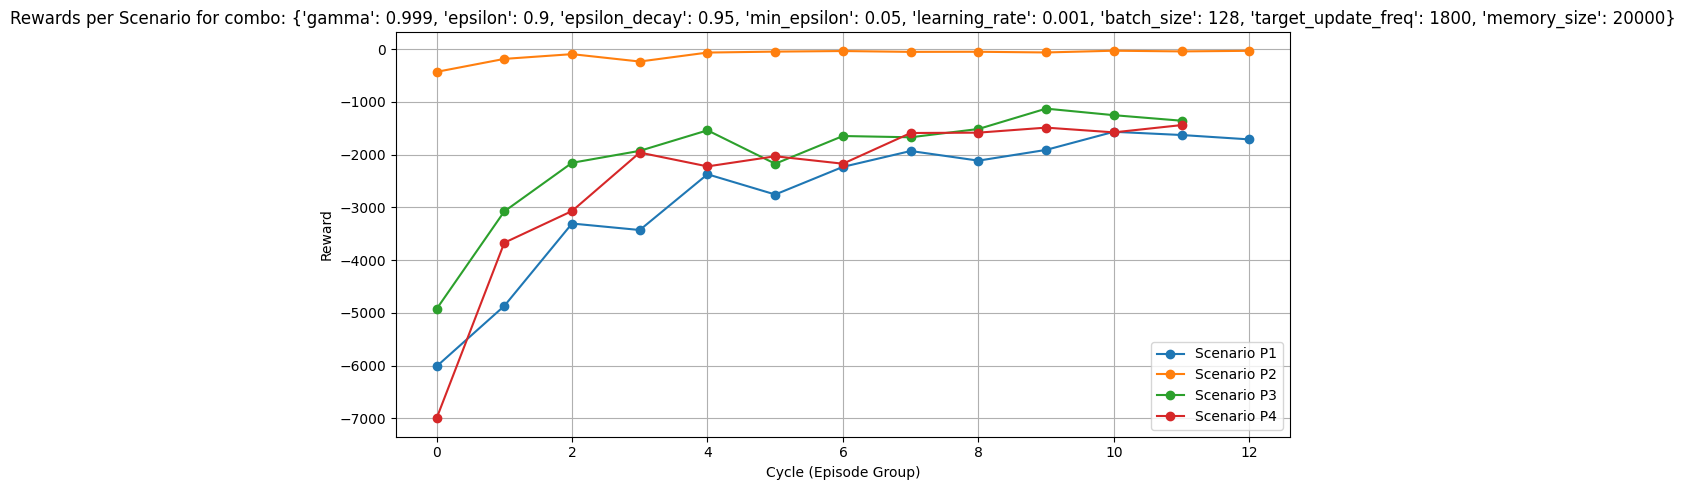

Running combo: {'gamma': 0.999, 'epsilon': 0.9, 'epsilon_decay': 0.97, 'min_epsilon': 0.05, 'learning_rate': 0.001, 'batch_size': 128, 'target_update_freq': 1800, 'memory_size': 10000}
Episode: 0
tensor(-5206.)
Episode: 1
tensor(-7754.)
Episode: 2
tensor(-6976.)
Episode: 3
tensor(-222.)
Episode: 4
tensor(-3493.)
Episode: 5
tensor(-4633.)
Episode: 6
tensor(-5124.)
Episode: 7
tensor(-121.)
Episode: 8
tensor(-2754.)
Episode: 9
tensor(-4714.)
Episode: 10
tensor(-5229.)
Episode: 11
tensor(-115.)
Episode: 12
tensor(-2886.)
Episode: 13
tensor(-3326.)
Episode: 14
tensor(-3076.)
Episode: 15
tensor(-106.)
Episode: 16
tensor(-2519.)
Episode: 17
tensor(-2211.)
Episode: 18
tensor(-3645.)
Episode: 19
tensor(-102.)
Episode: 20
tensor(-2192.)
Episode: 21
tensor(-1831.)
Episode: 22
tensor(-2583.)
Episode: 23
tensor(-52.)
Episode: 24
tensor(-1801.)
Episode: 25
tensor(-2456.)
Episode: 26
tensor(-2708.)
Episode: 27
tensor(-59.)
Episode: 28
tensor(-1501.)
Episode: 29
tensor(-2025.)
Episode: 30
tensor(-2763

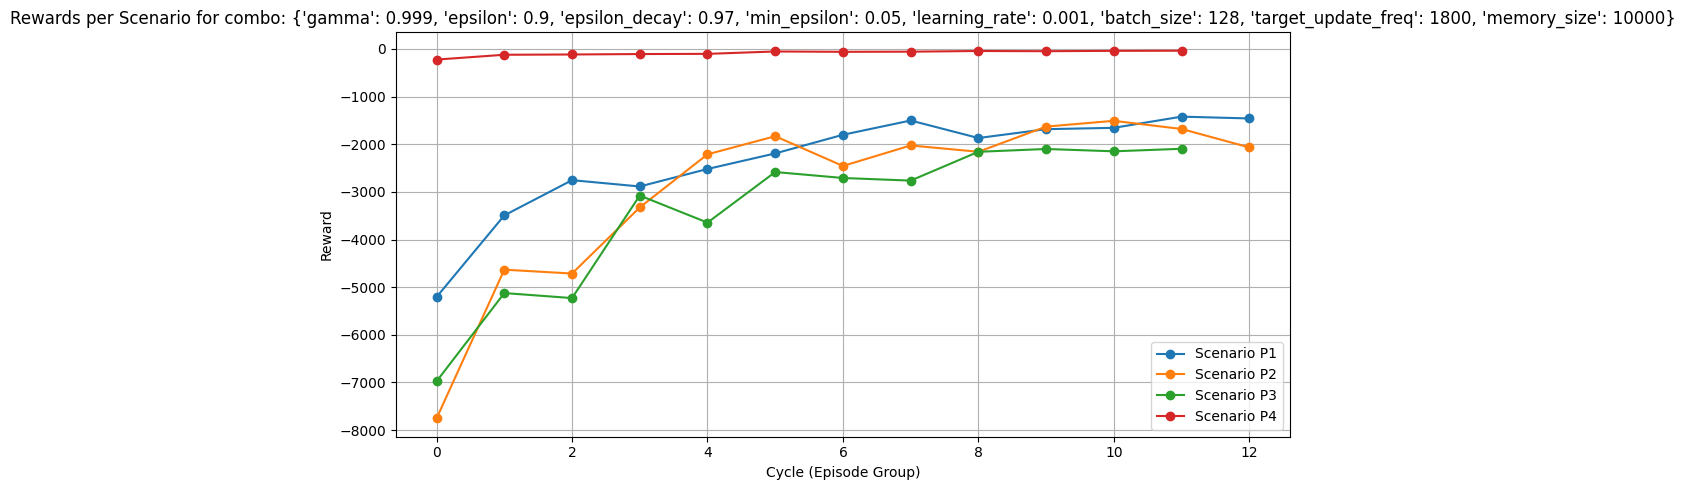

Running combo: {'gamma': 0.999, 'epsilon': 0.9, 'epsilon_decay': 0.97, 'min_epsilon': 0.05, 'learning_rate': 0.001, 'batch_size': 128, 'target_update_freq': 1800, 'memory_size': 20000}
Episode: 0
tensor(-6887.)
Episode: 1
tensor(-258.)
Episode: 2
tensor(-3168.)
Episode: 3
tensor(-6922.)
Episode: 4
tensor(-5447.)
Episode: 5
tensor(-214.)
Episode: 6
tensor(-2341.)
Episode: 7
tensor(-5723.)
Episode: 8
tensor(-4520.)
Episode: 9
tensor(-298.)
Episode: 10
tensor(-4219.)
Episode: 11
tensor(-4308.)
Episode: 12
tensor(-3766.)
Episode: 13
tensor(-162.)
Episode: 14
tensor(-2054.)
Episode: 15
tensor(-2339.)
Episode: 16
tensor(-2507.)
Episode: 17
tensor(-189.)
Episode: 18
tensor(-2063.)
Episode: 19
tensor(-2308.)
Episode: 20
tensor(-3215.)
Episode: 21
tensor(-51.)
Episode: 22
tensor(-2082.)
Episode: 23
tensor(-2160.)
Episode: 24
tensor(-2381.)
Episode: 25
tensor(-66.)
Episode: 26
tensor(-1759.)
Episode: 27
tensor(-2213.)
Episode: 28
tensor(-2758.)
Episode: 29
tensor(-70.)
Episode: 30
tensor(-2076.)

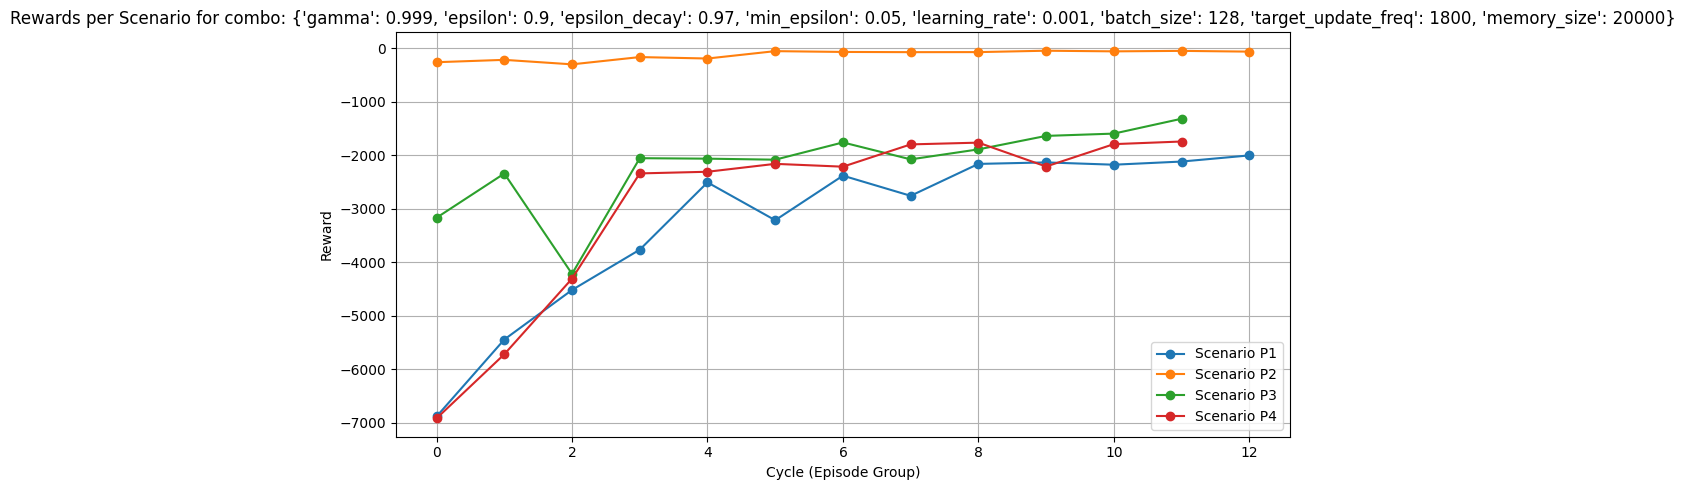

In [11]:
results = []

for combo in param_combinations:
    print(f"Running combo: {combo}")
    last_40_avg_reward, rewards_per_episode = train_algorithm(combo, episodes=50)
    combo_result = combo.copy()
    combo_result["last_40_avg_reward"] = last_40_avg_reward
    results.append(combo_result)

    num_scenarios = 4
    scenario_rewards = [[] for _ in range(num_scenarios)]

    for i, reward in enumerate(rewards_per_episode):
        scenario_index = i % num_scenarios
        scenario_rewards[scenario_index].append(reward)

    plt.figure(figsize=(10, 5))
    for i, rewards in enumerate(scenario_rewards):
        plt.plot(rewards, marker='o', label=f"Scenario P{i+1}")

    plt.xlabel('Cycle (Episode Group)')
    plt.ylabel('Reward')
    plt.title(f'Rewards per Scenario for combo: {combo}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results.csv", index=False)

In [14]:
# Show top 5 configs
print(results_df.sort_values("last_40_avg_reward", ascending=False).head())


   gamma  epsilon  epsilon_decay  min_epsilon  learning_rate  batch_size  \
0  0.999      0.9           0.95         0.05          0.001         128   
1  0.999      0.9           0.95         0.05          0.001         128   
2  0.999      0.9           0.97         0.05          0.001         128   
3  0.999      0.9           0.97         0.05          0.001         128   

   target_update_freq  memory_size  last_40_avg_reward  
0                1800        10000            -1417.95  
1                1800        20000            -1447.05  
2                1800        10000            -1725.75  
3                1800        20000            -1733.65  


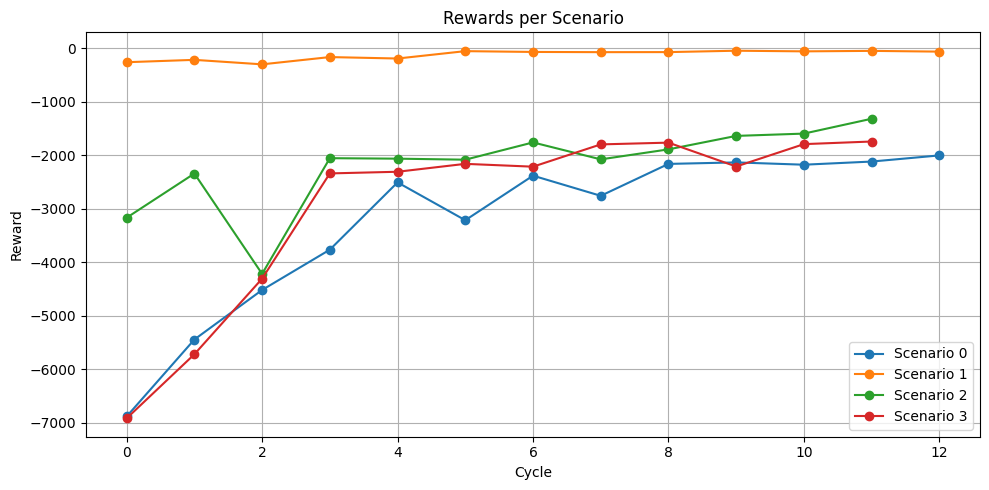

In [15]:
num_scenarios = 4

# Split the series into 4 separate lists
scenario_rewards = [[] for _ in range(num_scenarios)]
for i, reward in enumerate(rewards_per_episode):
    scenario_rewards[i % num_scenarios].append(reward)

# Plot each scenario as a separate line
plt.figure(figsize=(10, 5))
for i in range(num_scenarios):
    plt.plot(scenario_rewards[i], marker='o', label=f'Scenario {i}')

plt.xlabel('Cycle')
plt.ylabel('Reward')
plt.title('Rewards per Scenario')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
